In [2]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score, homogeneity_score,completeness_score, v_measure_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN



In [3]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Task 1. Implementing Kmeansв

In this task you will have to add code for the `MyKMeans` class. Using a simple example, we will see how cluster centers are selected and learn how to visualize them.

Let's generate a simple data set, 400 objects and 2 features (so that everything works quickly and can be easily drawn):


In [4]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Let's write a function `visualize_clusters`, which, based on the data and labels of clusters, will draw and color them:


In [5]:
def visualize_clusters(X, labels):
    """
    Function for visualizing clusters
         :param X: table objects x characteristics
         :param labels: np.array[n_samples] - cluster numbers
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

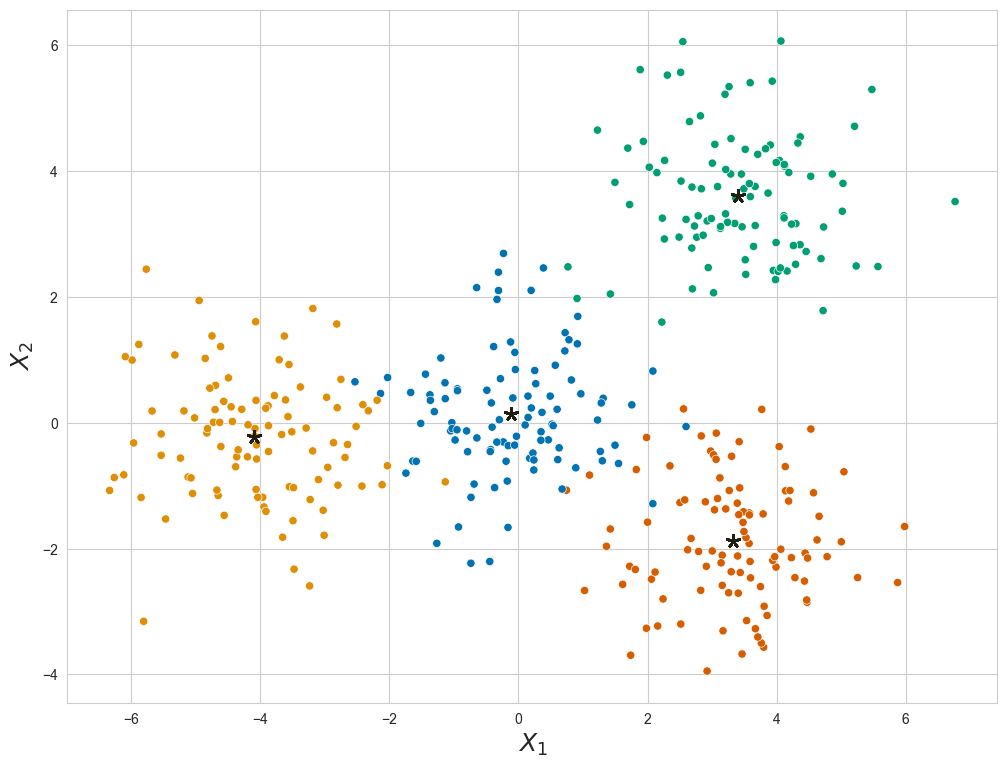

In [6]:
visualize_clusters(X, true_labels)

Let's write our own class `MyKMeans`, which will implement the K-means clustering algorithm. Let us recall the algorithm itself:

1. Select the number of clusters (K)
2. Randomly initialize K points (or select from the data), these will be the initial centers of our clusters
3. Next, for each object, we calculate the distance to all clusters and assign it the label of the closest
4. Next, for each cluster we calculate the “center of mass” (the average value for each feature for all objects in the cluster)
5. This "center of mass" becomes the new center of the cluster
6. Repeat steps 3, 4, 5 for a given number of iterations or until convergence

During prediction, the algorithm simply finds the nearest centroid (cluster center) for the test object and returns its number.

Implement the methods:
* `_calculate_distance(X, centroid)` - calculates the Euclidean distance from all objects in `X` to the given cluster center (`centroid`)
* `predict(X)` - for each element from `X` returns the number of the cluster to which this element belongs

In [7]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        MyKMeans class constructor
             :param n_clusters: number of clusters
             :param init: way to initialize cluster centers
                 'random' - generates coordinates randomly from a normal distribution
                 'sample' - selects centroids randomly from sample objects
             :param max_iter: specified number of iterations
                 (we will not implement another stopping criterion)
             :param visualize: whether to draw clusters and their centroids during operation
                 The code will take a lot longer, but it can be beautiful.
        """
        
        assert init in ["random", "sample"], f"Unknown initialization method {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Selects optimal cluster centers
            :param X: our data (n_samples, n_features)
            :return self: everything is like in sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Initializing centroids
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # We iteratively move the centers
        for _ in range(self.max_iter):
            # Let's calculate the distances for all objects to each centroid
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # For each object we find which centroid it is closer to
            cluster_labels = np.argmin(dists, axis=1)
            
            # Let's recalculate the center of mass for each cluster
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Let's draw the points, color them according to the cluster marks, and also draw the centroids
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        For each X, returns the number of the cluster it belongs to
            :param X: our data (n_samples, n_features)
            :return cluster_labels: cluster labels
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
        
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Calculates the Euclidean distance from all objects in X to a given cluster center (centroid)
             :param X: our data (n_samples, n_features)
             :param centroid: coordinates of the cluster center
             :return dist: distances from all X to the cluster center
        """
        dist = np.linalg.norm(X-centroid, axis=1).reshape(-1, 1)
        
        return dist
    
    
    def __repr__(self):
        return f"Hello, I'm your KMeans (/¯◡ ‿ ◡)/¯☆*"

Train `MyKMeans` on our toy data, achieve convergence. Don't forget to set `visualize=True` to look at the beautiful pictures. Also try different ways to initialize centroids and tell me which one worked better in this situation.

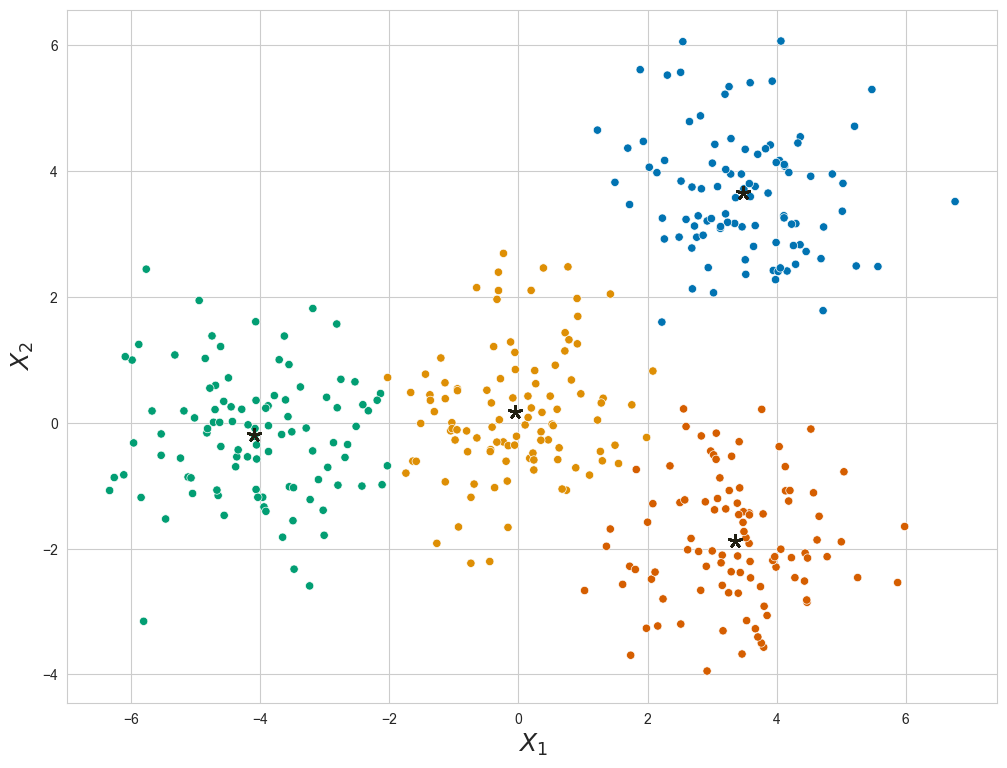

Hello, I'm your KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
kmeans = MyKMeans(4, max_iter=7, visualize=True)

kmeans.fit(X)

In [9]:
for start in ['random','sample']:
    for iters in [4, 5, 6, 8, 10]:
        kmeans = MyKMeans(4, init=start, max_iter=iters, visualize=False)
        kmeans.fit(X)
        pred_labels = kmeans.predict(X)
        print(f'_________{start=}____{iters=}________________')
        print(f'{silhouette_score(X, pred_labels)=}')
        print(f'{rand_score(true_labels, pred_labels)=}')
        print(f'{adjusted_rand_score(true_labels, pred_labels)=}\n')

_________start='random'____iters=4________________
silhouette_score(X, pred_labels)=0.5643117184043004
rand_score(true_labels, pred_labels)=0.9730827067669173
adjusted_rand_score(true_labels, pred_labels)=0.9278697796079957

_________start='random'____iters=5________________
silhouette_score(X, pred_labels)=0.5643117184043004
rand_score(true_labels, pred_labels)=0.9730827067669173
adjusted_rand_score(true_labels, pred_labels)=0.9278697796079957

_________start='random'____iters=6________________
silhouette_score(X, pred_labels)=0.5643117184043004
rand_score(true_labels, pred_labels)=0.9730827067669173
adjusted_rand_score(true_labels, pred_labels)=0.9278697796079957

_________start='random'____iters=8________________
silhouette_score(X, pred_labels)=0.5643117184043004
rand_score(true_labels, pred_labels)=0.9730827067669173
adjusted_rand_score(true_labels, pred_labels)=0.9278697796079957

_________start='random'____iters=10________________
silhouette_score(X, pred_labels)=0.5643117184043

Any option with max_iter>=6 looks quite adequate. both for random starting points and pre-selected ones.

### Task 2. Selecting the best hierarchical clustering

The lecture discussed various distances that can serve as metrics of difference between objects. We also analyzed several clustering algorithms, including hierarchical. It can often be unclear which algorithm and which distance metric to take. Let's simplify our life and write a function `algorithm_selection`, which will be based on the following passed to it:

* distance metrics (you can take everything that was in lectures, at least 4)
* `linkage` parameter ('average', 'single', 'complete')
* and clustering quality metrics ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

will output a final table that will include the following columns:
* distance (distance metric)
* linkage (hierarchical clustering algorithm)
* homogeneity
* completeness
*  v_measure
*silhouette

As a result, based on this table, you need to draw a conclusion about which clustering algorithm and with which hyperparameters worked best.

Let's load our data:


In [10]:
data = load_digits()
X, y = data.data, data.target

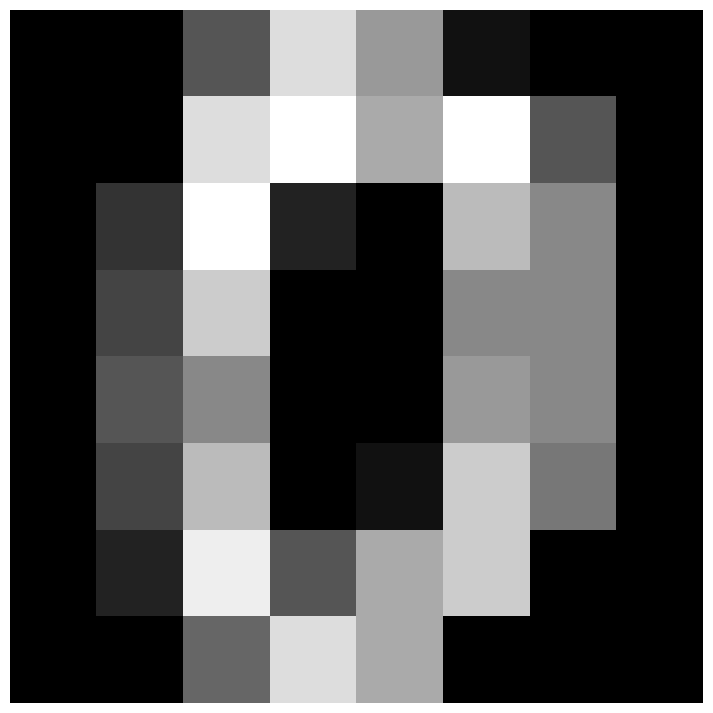

In [11]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

We will work with images of handwritten numbers. Here everything is similar to the data for homework 1, each picture is represented by a vector of 64 elements (numbers from 0 to 255). To draw it we must `reshape` it into an 8 by 8 pixel image. You will need to select the best clustering method using the `algorithm_selection` function you implement. Some clustering metrics require object **class** labels (stored in the `y` variable). Specify for each algorithm the number of clusters equal to the number of classes in `y`.

In [12]:
def algorithm_selection(X, distances, algorithms, metrics,n_clust=10, y_true=None):
    """
    For given clustering algorithms and hyperparameters 
        considers various clustering metrics
         :param X: our data (n_samples, n_features)
         :param distances: list of possible distance metrics
         :param algorithm: linkage parameter ('average', 'single', 'complete')
         :param metrics: list of possible clustering quality metrics
         :return compare_dataframe: table with clustering metrics
    """

    compare_dict = {'distance': [], 'linkage': []}
    for metric in metrics:
        compare_dict[metric] = []
    for alg in algorithms:
        for dist in distances:
            agg_model = AgglomerativeClustering(n_clusters=n_clust, affinity=dist, linkage=alg)
            y_pred = agg_model.fit_predict(X)
            compare_dict['distance'].append(dist)
            compare_dict['linkage'].append(alg)
            if 'homogeneity' in metrics:
                compare_dict['homogeneity'].append(homogeneity_score(y_true, y_pred))
            if 'completeness' in metrics:
                compare_dict['completeness'].append(completeness_score(y_true, y_pred))
            if 'v_measure' in metrics:
                compare_dict['v_measure'].append(v_measure_score(y_true, y_pred))
            if 'silhouette' in metrics:
                compare_dict['silhouette'].append(silhouette_score(X, y_pred))
                                              
                                              
        
    compare_dataframe = pd.DataFrame(compare_dict)
    
    return compare_dataframe

distances = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'canberra']
algorithms = ['average', 'single', 'complete']
metrics = ['homogeneity', 'completeness', 'v_measure', 'silhouette']
compare_dataframe = algorithm_selection(X, y_true=y, distances=distances, algorithms=algorithms, metrics=metrics)
compare_dataframe

distance   linkage  homogeneity  completeness  v_measure  silhouette
0   euclidean   average     0.655393      0.782342   0.713263    0.146625
1   manhattan   average     0.566751      0.778942   0.656117    0.089217
2      cosine   average     0.648268      0.808762   0.719676    0.129526
3   chebyshev   average     0.769464      0.828645   0.797959    0.173900
4    canberra   average     0.573860      0.779789   0.661161    0.094335
5   euclidean    single     0.005056      0.273755   0.009929   -0.133621
6   manhattan    single     0.005102      0.276237   0.010019   -0.166627
7      cosine    single     0.005050      0.273389   0.009916   -0.158250
8   chebyshev    single     0.006129      0.281430   0.011996   -0.087260
9    canberra    single     0.006144      0.280506   0.012025   -0.181136
10  euclidean  complete     0.590549      0.637772   0.613253    0.119271
11  manhattan  complete     0.646372      0.686109   0.665648    0.140183
12     cosine  complete     0.528727      0.577415   0.551999    0.088021
13  chebyshev  complete     0.067111      0.412582   0.115444   -0.193835
14   canberra  complete     0.528702      0.561588   0.544649    0.099416

By any metric, **chebyshev-average** is the best

### Task 3. Annotation of cell types


In this assignment, you will apply what you have learned about clustering to annotate flow cytometry data. Each row in the data is one cell, the columns **FSC-A**, **SSC-A** indirectly indicate the size of the cells, the rest show the fluorescence intensity of various surface markers. Your task is to determine for each cell what type it belongs to.

#### 3.1. EDA

Carry out EDA:

1. Look at the data (you can try the `describe` method)
2. How many cells/features do we have?
3. Plot the distributions of each attribute (are there any obvious outliers?)

In [13]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

In [119]:
fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c  
0    -1.406912  0.384406  
1     6.034845  0.577039  
2    -0.318668 -0.493832  
3     0.694883  3.416960  
4     5.563345  0.471591  
...        ...       ...  
9995 -0.591343  2.857737  
9996  0.344169 -0.626795  
9997 -0.887078  4.369294  
9998 -0.112999  0.069239  
9999 -0.441455  0.378331  

[10000 rows x 9 columns]

In [120]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


9 features, 10,000 samples, all float, not a single empty value


In [14]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

Looks like there are outliers

<Axes: >

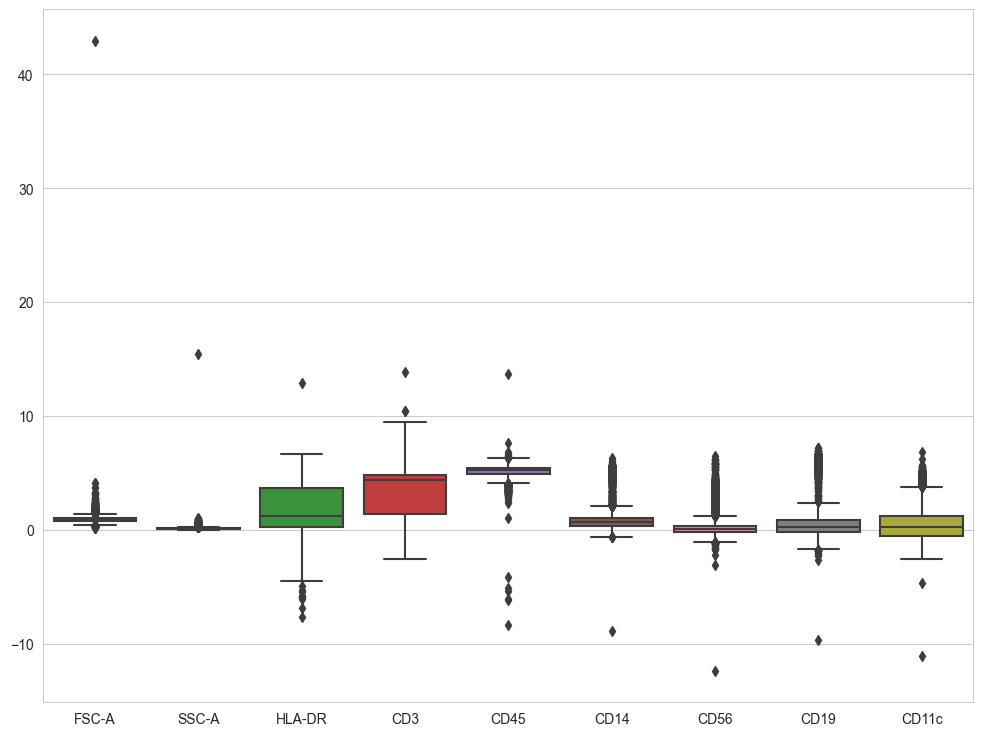

In [15]:
sns.boxplot(data=fc_data)

And indeed, here they are. At least one

<Axes: >

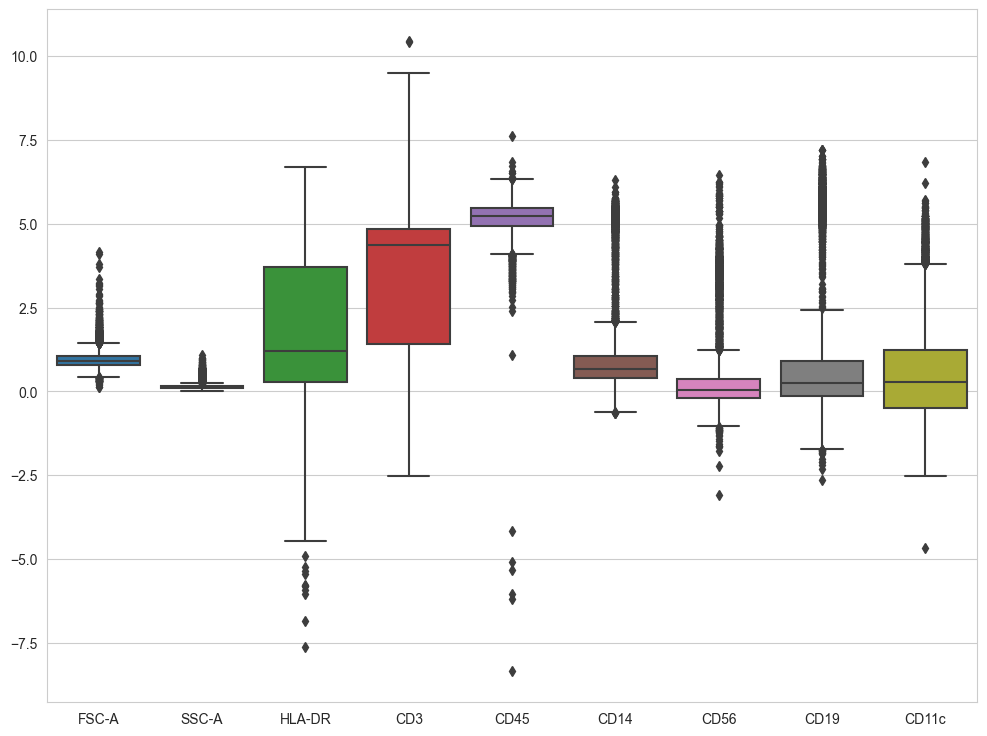

In [16]:
sns.boxplot(data=fc_data[fc_data['FSC-A']<40])

ак гораздо лучше

In [17]:
fc_data=fc_data[fc_data['FSC-A']<40]

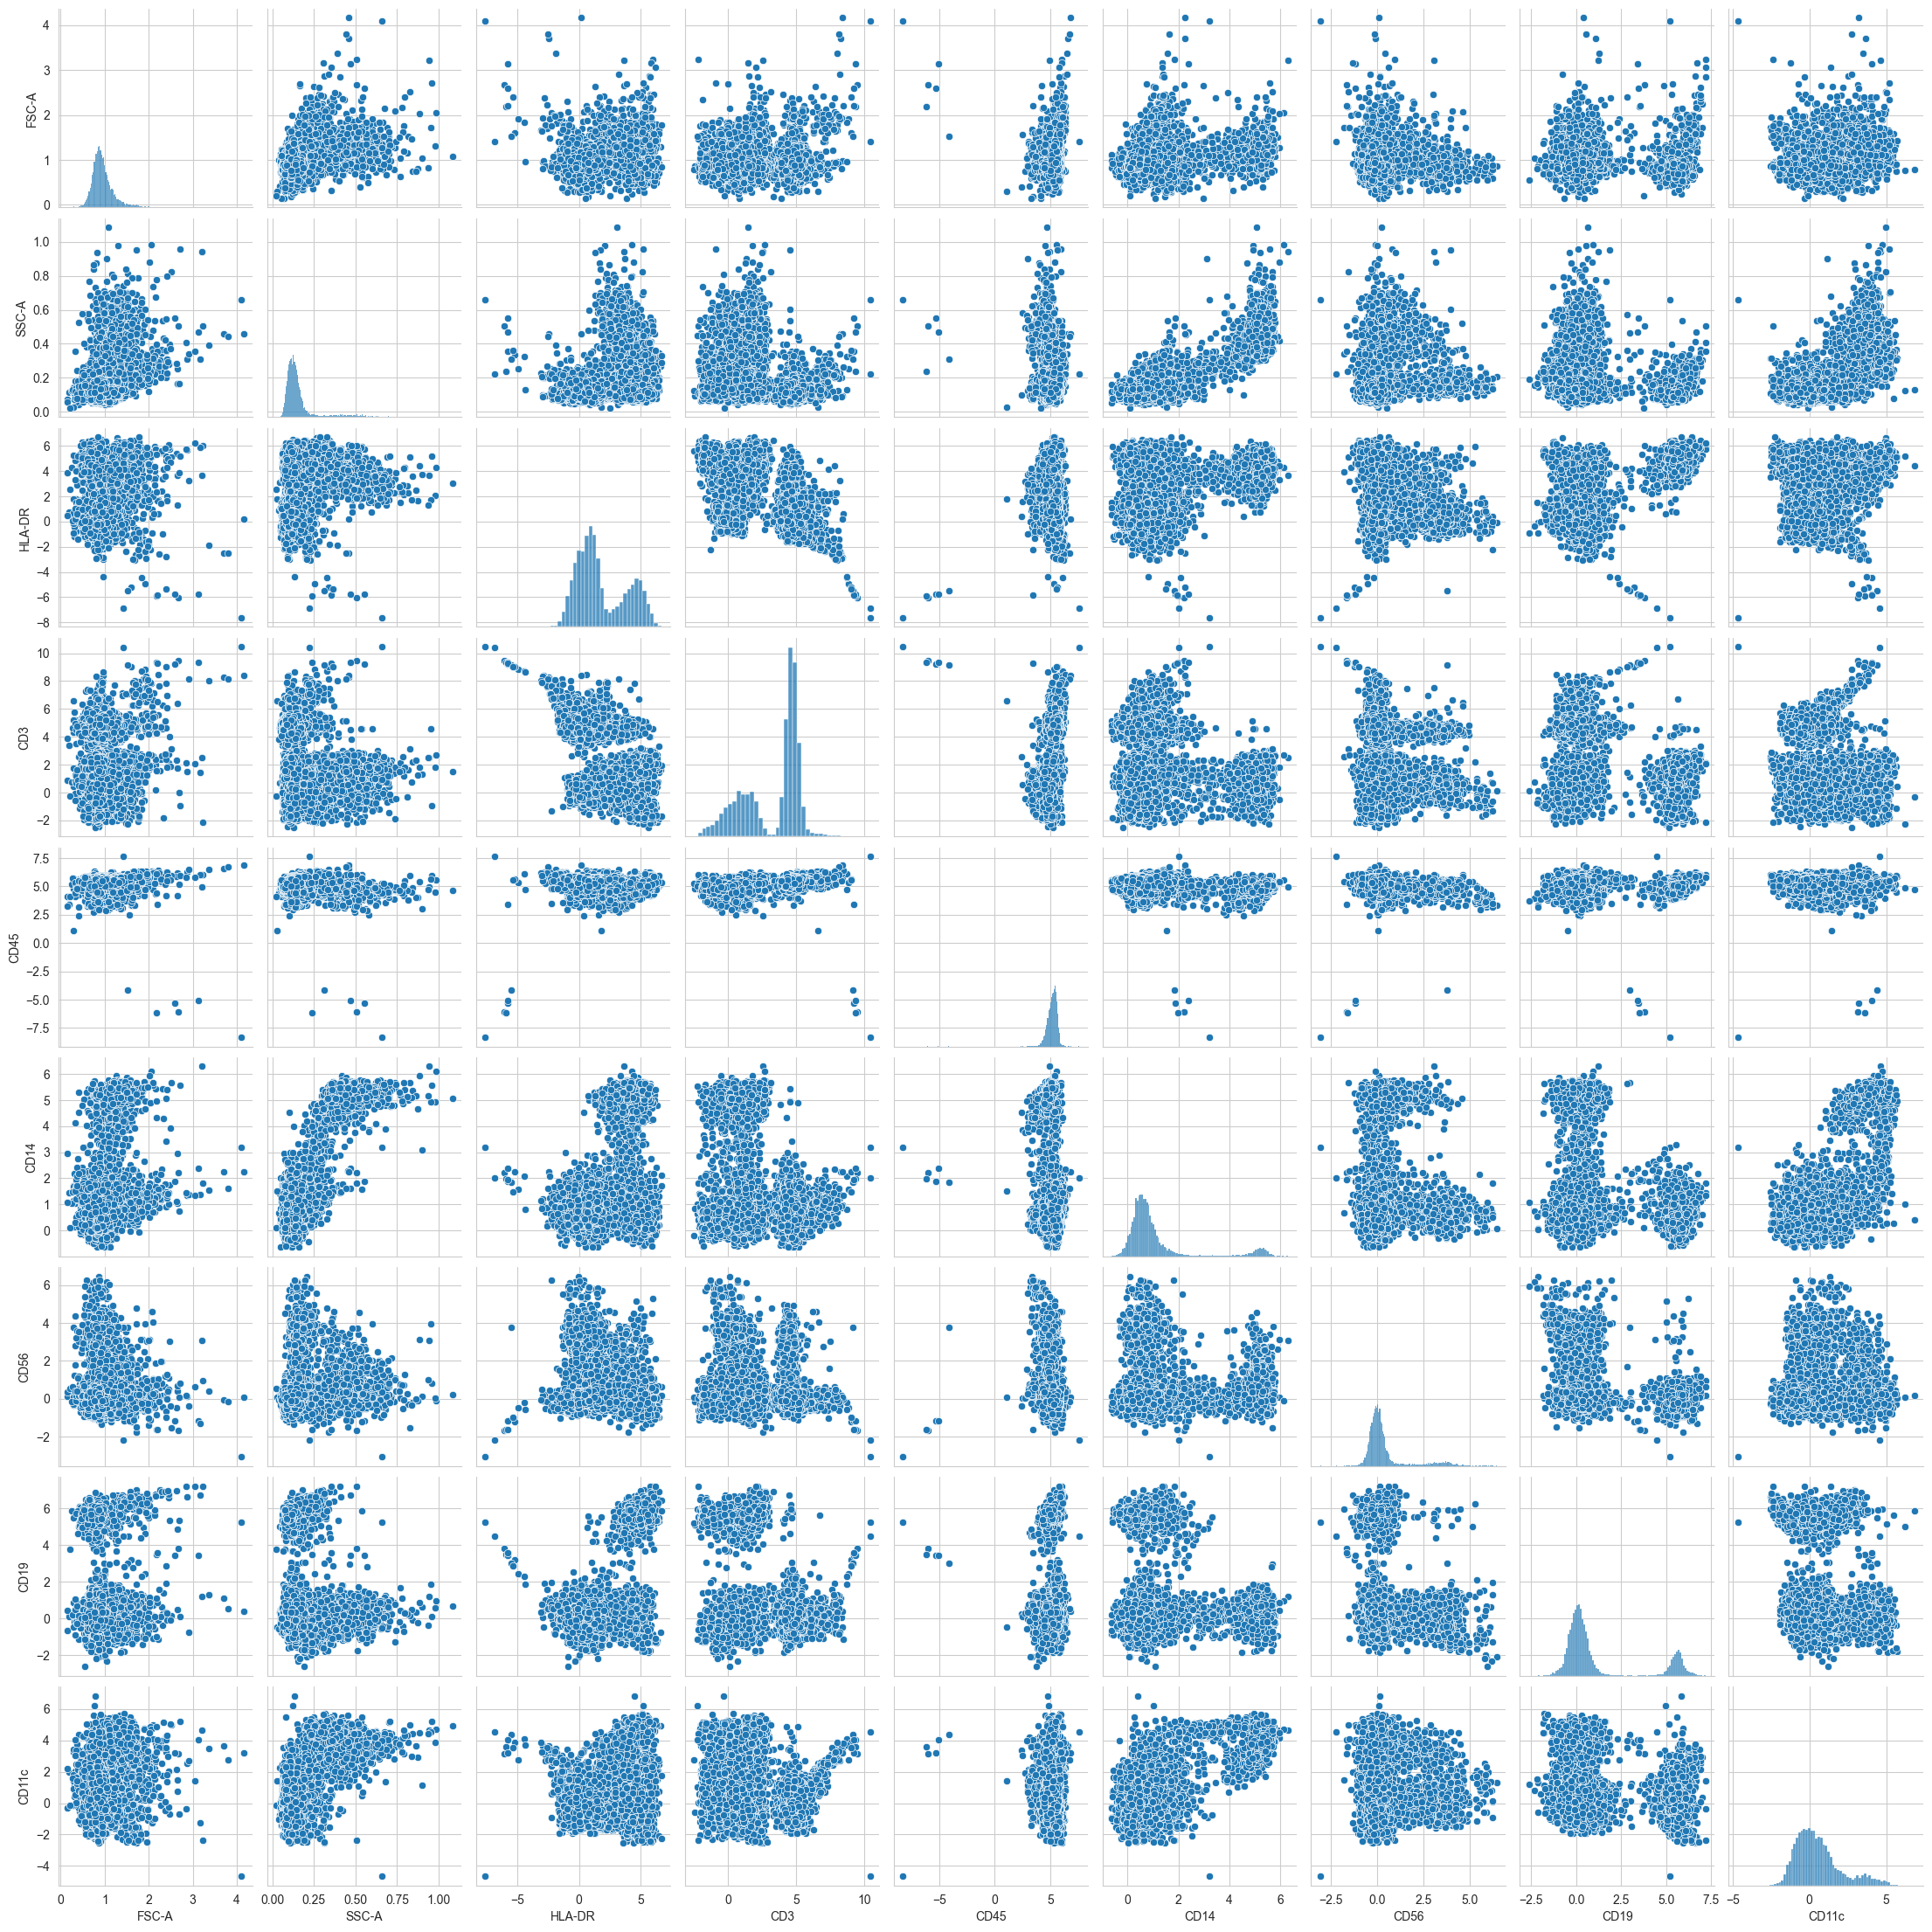

In [18]:
sns.pairplot(fc_data)

Beautiful. Clusters are already visible for some variables

#### 3.2. Clustering


When manually annotating cell types, one typically proceeds as follows:

1. Using dimensionality reduction techniques, we plot our observations to roughly estimate the number of cell types
2. Conduct clustering of observations (for some methods you need to set the number of clusters in advance, so step 1 helps us)
3. Next, we assume that the cells that the algorithm assigned to one cluster are one cell type (if there are more clusters than cell types, then it is possible that 2 different clusters are the same type)
4. Then, based on the intensity of expression of surface markers, we assign a cell type to the cluster

Let's first write a convenient function for visualizing our multidimensional data in a space of dimension 2, we will do this using the t-SNE algorithm.

You can play around with beautiful visualizations [here](https://distill.pub/2016/misread-tsne/).

In [19]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Function for drawing the results of t-SNE work
         :param data: table objects x features
         :param n_iter: number of gradient descent iterations,
             it may be useful to zoom in to get better results
         :param perplexity:  perplexity is related to the number of nearest neighbors. 
             Consider netween 5 and 50
         :param color: np.array[n_samples] with variable,
             with which we want to color our observations
         :return tsne_emb: np.array[n_samples, 2] - results of t-SNE work
    """
    
    # Let's do PCA first since it's a good starting approximation for t-SNE 
    # wich allows the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Let's run t-SNE, it will give us 2 numbers for each object that we can draw
    tsne = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tsne.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Let's also return the t-SNE results, because if we later want to rebuild the picture,
    # in this case we won't have to wait again, we'll just draw a new one with ready-made data
    
    return tsne_embedding

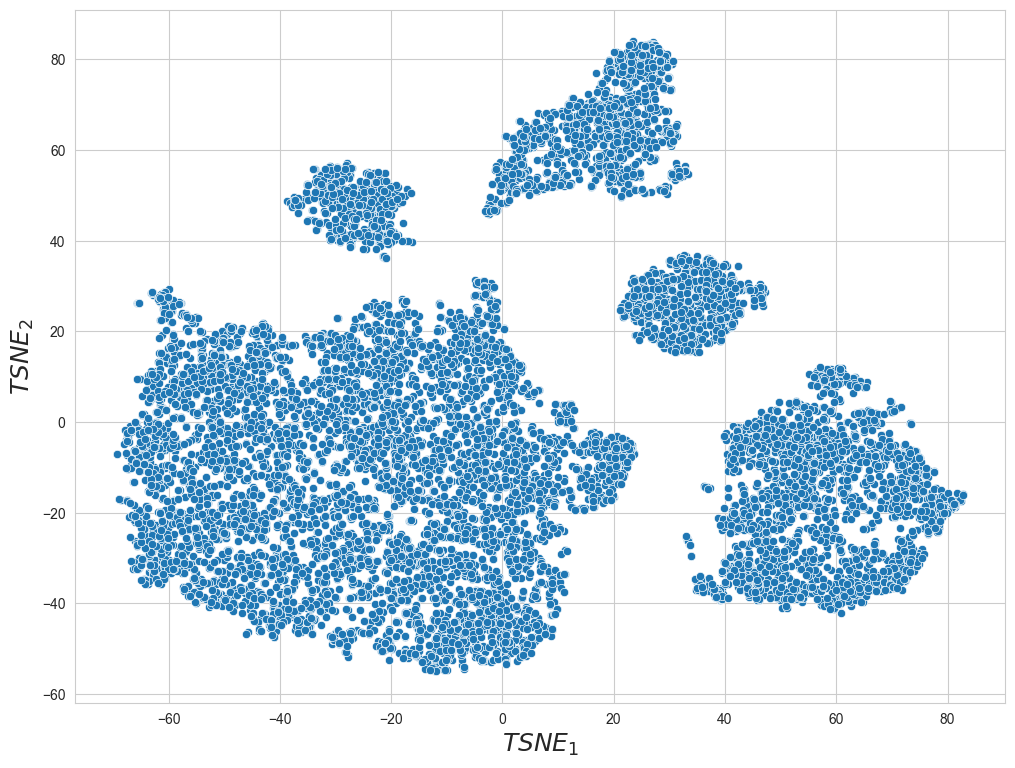

In [20]:
tsne_res = plot_tsne(fc_data)

We will assume that there are 5 clusters

Cluster your data:

1. Try the clustering methods we went through
2. Choose the best one based on the `silhouette_score` metric (try also choosing hyperparameters)
3. Assign each observation a class label and draw a t-SNE plot, coloring the points with cluster labels

In [21]:
kmeans = KMeans(n_clusters=5, random_state=SEED)
preds = kmeans.fit_predict(fc_data)
# plot_tsne(fc_data,color=preds)
print(silhouette_score(fc_data, preds))

0.351058511556979


In [22]:
kmeans = KMeans(n_clusters=4, random_state=SEED)
preds = kmeans.fit_predict(fc_data)
# plot_tsne(fc_data,color=preds)
print(silhouette_score(fc_data, preds))

0.6109319182864639


In [23]:
kmeans = KMeans(n_clusters=6, random_state=SEED)
preds = kmeans.fit_predict(fc_data)
# plot_tsne(fc_data,color=preds)
print(silhouette_score(fc_data, preds))

0.3633782592398674


In [25]:
algorithm_selection(fc_data,n_clust=4, distances=distances, algorithms=algorithms, metrics=['silhouette'])

distance   linkage  silhouette
0   euclidean   average    0.449268
1   manhattan   average    0.403770
2      cosine   average    0.610367
3   chebyshev   average    0.496403
4    canberra   average    0.233483
5   euclidean    single    0.635343
6   manhattan    single    0.635343
7      cosine    single    0.198020
8   chebyshev    single    0.635343
9    canberra    single    0.074590
10  euclidean  complete    0.470696
11  manhattan  complete    0.475199
12     cosine  complete    0.519763
13  chebyshev  complete    0.507590
14   canberra  complete    0.587274

cosine average, euclidean single or manhattan single

In [26]:
agg_model = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='average')
preds = agg_model.fit_predict(fc_data)

# plot_tsne(fc_data,color=preds)
print(silhouette_score(fc_data, preds))

0.613180242512952


In [27]:
agg_model = AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average')
preds = agg_model.fit_predict(fc_data)

# plot_tsne(fc_data,color=preds)
print(silhouette_score(fc_data, preds))

0.5760998386995317


In [28]:
agg_model = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average')
preds = agg_model.fit_predict(fc_data)

# plot_tsne(fc_data,color=preds)
print(silhouette_score(fc_data, preds))

0.6103672462689237


In [29]:
# DBSCAN

for eps in [1, 1.5, 2, 2.5]:
    for min_samples in [5, 10, 20, 50, 100, 150, 200, 300]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(fc_data)
        labels = db.labels_
        preds = db.fit_predict(fc_data)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f'____{eps=}____{min_samples=}___')
        print(f'{silhouette_score(fc_data, preds)=}')
        print(f'{n_clusters=}\n')

____eps=1____min_samples=5___
silhouette_score(fc_data, preds)=0.20181530116013538
n_clusters=15

____eps=1____min_samples=10___
silhouette_score(fc_data, preds)=0.4770440718918736
n_clusters=6

____eps=1____min_samples=20___
silhouette_score(fc_data, preds)=0.47003038699842226
n_clusters=4

____eps=1____min_samples=50___
silhouette_score(fc_data, preds)=0.35599309445125404
n_clusters=4

____eps=1____min_samples=100___
silhouette_score(fc_data, preds)=0.3399797934770905
n_clusters=2

____eps=1____min_samples=150___
silhouette_score(fc_data, preds)=0.27835382260964997
n_clusters=2

____eps=1____min_samples=200___
silhouette_score(fc_data, preds)=0.39558429451674365
n_clusters=1

____eps=1____min_samples=300___
silhouette_score(fc_data, preds)=0.3764051498305396
n_clusters=1

____eps=1.5____min_samples=5___
silhouette_score(fc_data, preds)=0.5244453100628171
n_clusters=6

____eps=1.5____min_samples=10___
silhouette_score(fc_data, preds)=0.5985771247997215
n_clusters=4

____eps=1.5____min

Based on the results of the tests and based on the next task, **the number of clusters will be considered = 4**, and we will take **kmeans** as the algorithm.

array([[ 40.84076661,  28.18320219],
       [ 52.01454632, -19.50947489],
       [-51.91205002, -20.01415787],
       ...,
       [ -0.32039733,  52.39967344],
       [ 32.10784221,  24.16932536],
       [ 39.06905401,  22.81326195]])

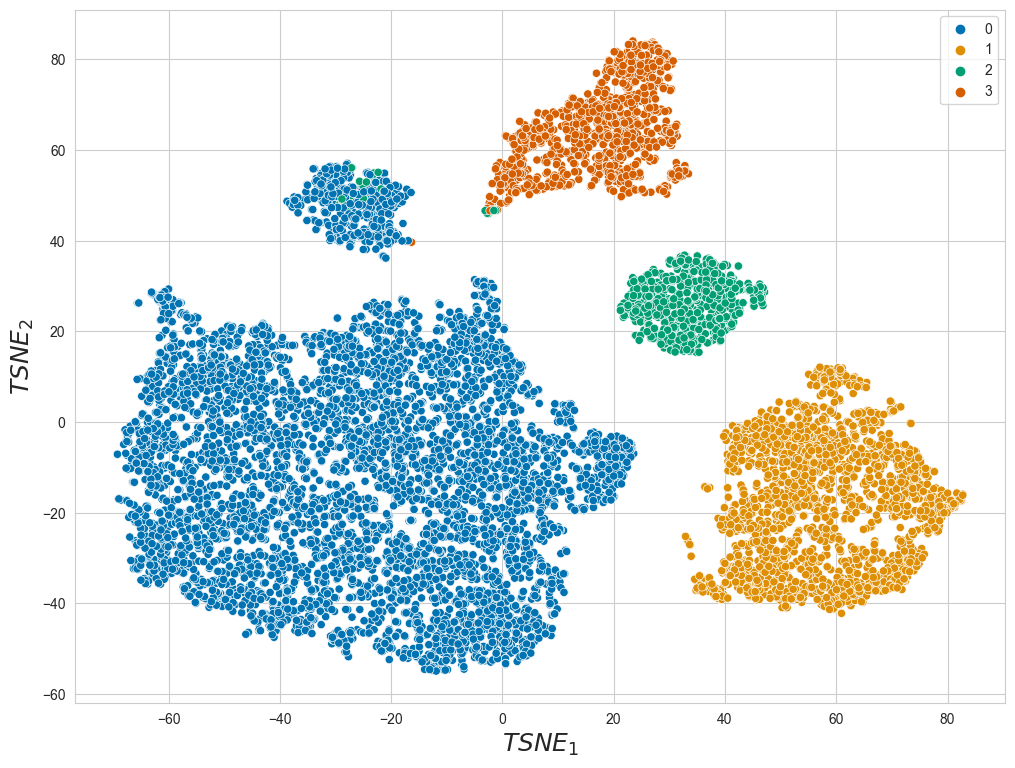

In [30]:
kmeans = KMeans(n_clusters=4, random_state=SEED)
preds = kmeans.fit_predict(fc_data)
plot_tsne(fc_data,color=preds)


Have you managed to get a situation where separate groups of dots are painted the same color?

Good enoughI h Hope. Some cells unexpectedly clustered into class 3

#### 3.3. Cell type annotation


Now that we have selected a good clustering algorithm, we can annotate our cells. To do this, we will draw a t-SNE and color the points depending on the intensity of surface marker expression. The dataset contains the following cell types:

* B_cells
* T_cells
* Monocytes
* Other cells

You will need to figure out which cells express certain markers and assign each cluster to one of the cell types.

First, let's draw all this mess:

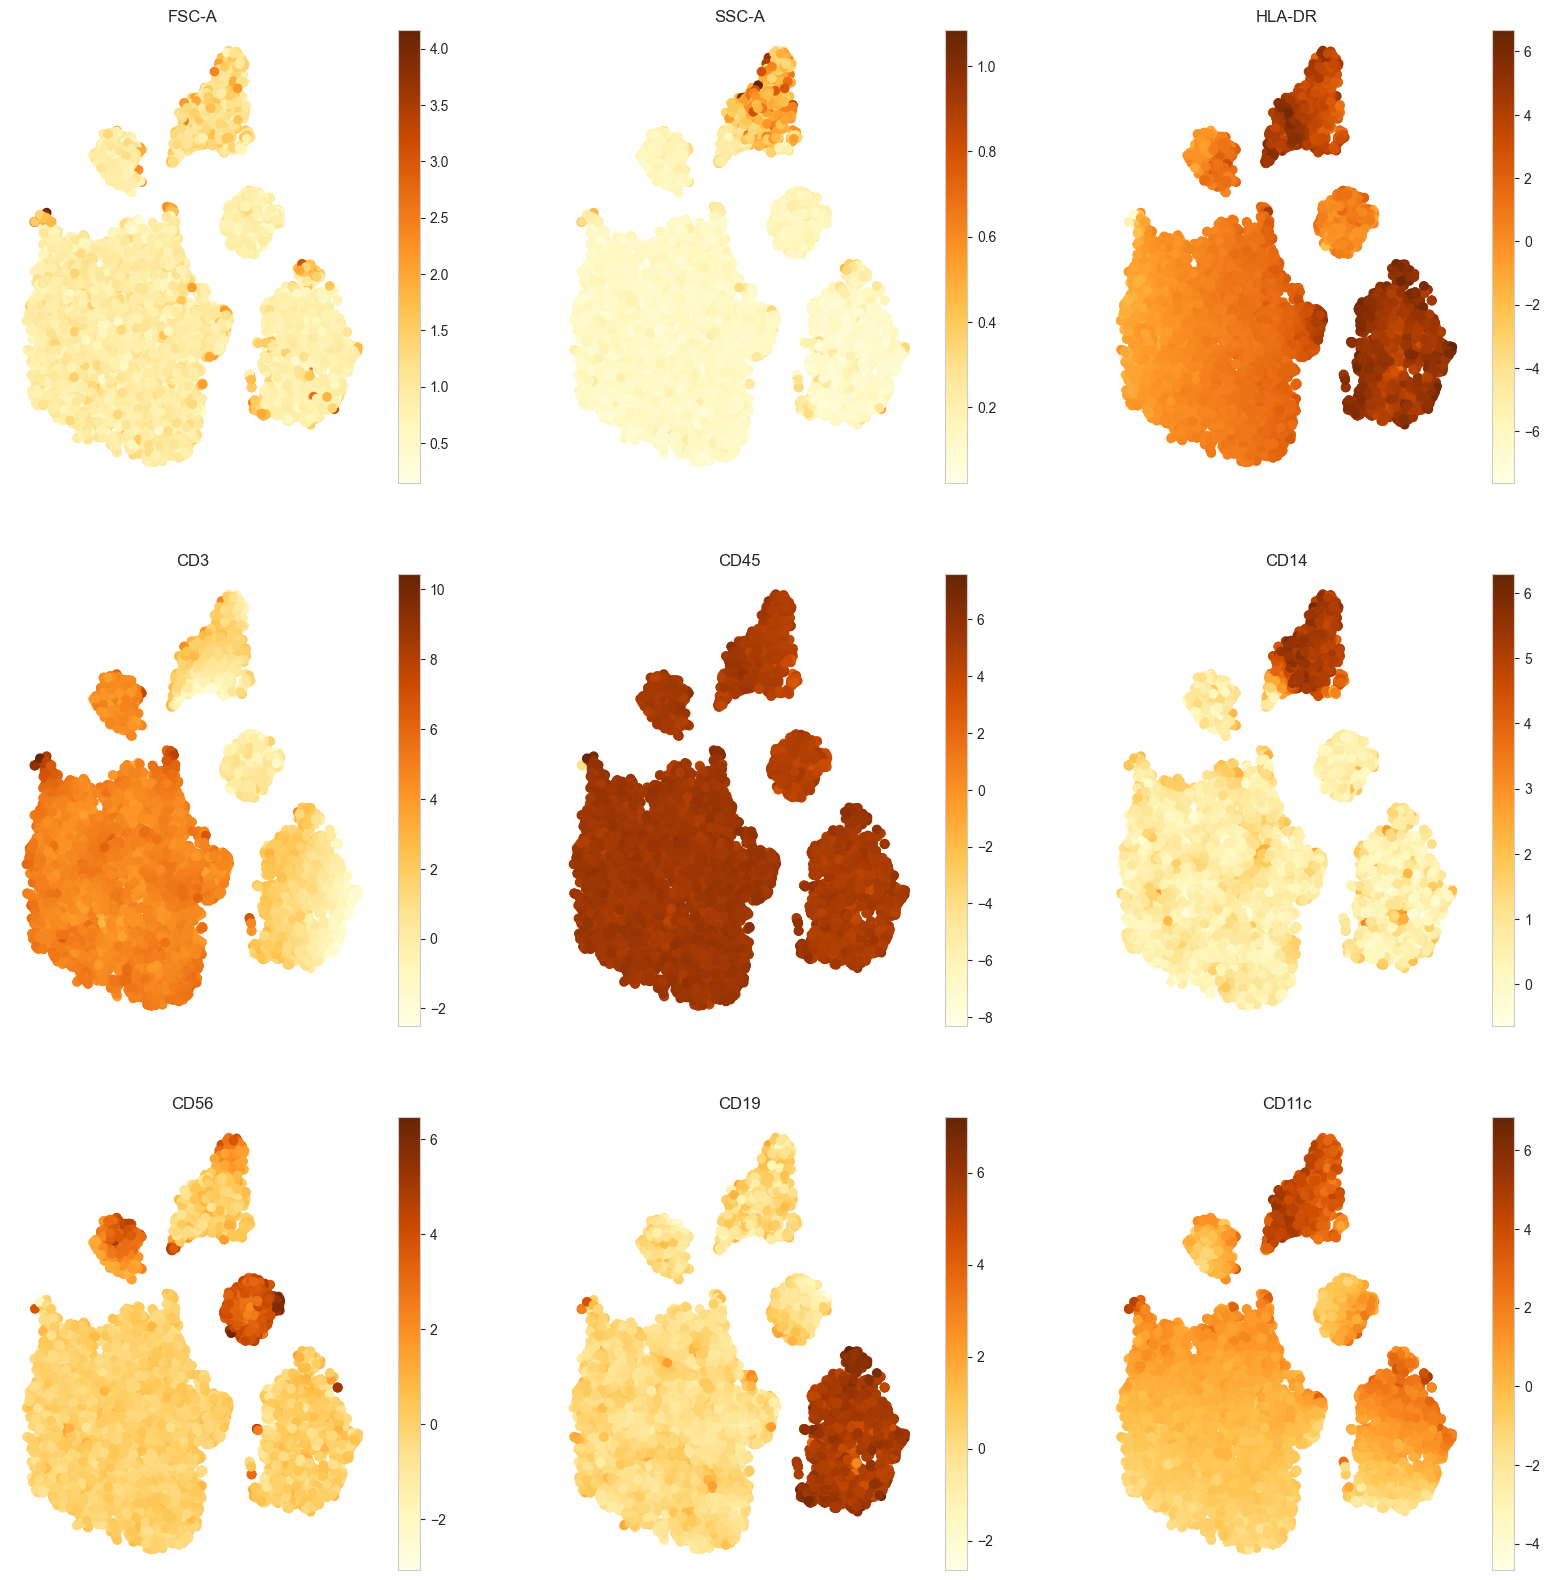

In [31]:
# The t-SNE results are already in the tsne_res variable
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Now we need to determine the cell type for each cluster and write them down as values ​​in a dictionary:

**Sudoku :)**  By CD19 (main marker of B-cells) - cluster1 -`B_cell`;  
By CD14 (macrophage marker) - cluster3 `Monocytes`;  
By CD3 (T-cell marker) - cluster0 - ` - T_cells`;  
All others - `Other_cells`

In [32]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Other_cells", 
                         3: "Monocytes"}

In [33]:
labeled_fc_data = fc_data.assign(Population=kmeans.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Calculate how cell types are distributed

In [35]:
labeled_fc_data.Population.value_counts()

Population
T_cells        6200
B_cells        2035
Monocytes      1091
Other_cells     673
Name: count, dtype: int64

Save your results to a csv file, we will compare them with the correct answers using the `f1_score(average="macro")` metric, which works well even if the classes are not balanced.

In [36]:
labeled_fc_data.to_csv('./data/result.csv')



Dmitrii Poliakov, [2/27/2022 10:42 PM]
Так, а как мне в доп. задании по клеточкам посчитать F1, если я не знаю правильного фенотипа, а знаю только предсказанный?

Dmitrii Poliakov, [2/27/2022 10:43 PM]
Или я беру предсказанные, строю классификатор и сравниваю предсказанные классификатором с предсказанными кластеризатором?)